# Step 03: Baseline Performance

In this notebook, we'll be running the DeepFashion dataset through some simple models. No data cleaning or hyperparameter tuning will be performed. 

🔗 Code adapted from: 

1.   [Mod5_FashionRecommendations Repo](https://github.com/MsJacksonIYN/Mod5_FashionRecommendations/blob/master/Notebooks_CNNs/Cleaning_and_Training_Fabric.ipynb)
2.   [Building a Personalized Real-Time Fashion Collection Recommender](https://towardsdatascience.com/building-a-personalized-real-time-fashion-collection-recommender-22dc90c150cb)

⚠️  Note: 
**gdown** isn't a great option if you want to repeatedly access big files for a number of reasons (Google imposed daily limit to # of downloads, 3rd party bugs, etc). It's best to use Google Colab as it was designed & that includes built in methods for accessing files & folders from your Drive (even if they're not owned by you). 

See more details below 👇🏻:
* [accessing “Shared with me” with Colab](https://stackoverflow.com/questions/54351852/accessing-shared-with-me-with-colab)

* [Build Code Collaboration with Google Colab](https://towardsdatascience.com/an-effective-way-of-managing-files-on-google-colab-ac37f792690b)

* [External data: Local Files, Drive, Sheets, and Cloud Storage](https://colab.research.google.com/notebooks/io.ipynb#scrollTo=u22w3BFiOveA)

# 0. Set-up Environment

In [1]:
# #reference: 
# #https://forums.fast.ai/t/how-to-find-similar-images-based-on-final-embedding-layer/16903

# # install fastai for the hook and annoy for approximate nearest neighbors 
!pip install fastai
!pip install annoy


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from fastai.vision import *
from fastai.metrics import accuracy, top_k_accuracy
from annoy import AnnoyIndex
import zipfile
import time
from google.colab import drive
%matplotlib inline

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
train_on_gpu = torch.cuda.is_available()
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ... To use GPU, go under edit > notebook settings')
else:
    print('CUDA is available!  Training on GPU ...')
    print(gpu_info)

CUDA is available!  Training on GPU ...
Sun Mar 14 03:50:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                

# 1. Get DeepFashion Data

DeepFashion data set: http://mmlab.ie.cuhk.edu.hk/projects/DeepFashion.html

We are using v2 of the data, with 24K+ images.

## Files/Folders Information

* Anno_coarse (16.6 MB)/
        * list_attr_cloth.txt
        * list_attr_img.txt
        * list_bbox.txt
        * list_category_cloth.txt
        * list_category_img.txt
        * list_landmarks.txt
        
* Anno_fine/
        * (see all files above)
        * train_attr.txt, train_bbox.txt, train_cate.txt, train_landmarks.txt, train.txt
        * test_attr.txt, test_bbox.txt, test_cate.txt, test_landmarks.txt, test.txt
        * val_attr.txt, val_bbox.txt, val_cate.txt, val_landmarks.txt, val.txt
* Eval/
        * list_eval_partition.txt
* Img/
        * img_highres.zip (28 GB)
        * img.zip (2 GB)



## Get Metadata Code

In [5]:
parent_folder_url = '/content/drive/My Drive/DeepFashion/Category and Attribute Prediction Benchmark/'

⚠️ One big issue: We're missing some categories of clothing.

Clothing categories file contains 50 entries, whereas the image_category_cloth file is only showing 48. We're specifically missing 'shitdress' and 'sundress'.

📝 This can posible be explained by the note:

"For the clothing categories, "Cape", "Nightdress", "Shirtdress" and "Sundress" have been merged into "Dress""



In [6]:
#create & preview df of attrbiute names & type label
file_url = 'Anno_coarse/list_category_cloth.txt'

list_category_cloth_df = pd.read_table(f'{parent_folder_url}{file_url}',
                                   sep='\s{2,}', 
                                   header=0, 
                                   skiprows=[0], 
                                   engine='python')
list_category_cloth_df.head()

category_name  category_type
0        Anorak              1
1        Blazer              1
2        Blouse              1
3        Bomber              1
4   Button-Down              1

In [7]:
file_url = 'Anno_coarse/list_category_img.txt'

list_category_img_df = pd.read_table(f'{parent_folder_url}{file_url}',
                                   sep='\s{2,}', 
                                   header=0, 
                                   skiprows=[0], 
                                   engine='python')
list_category_img_df.head()

image_name  category_label
0  img/Sheer_Pleated-Front_Blouse/img_00000001.jpg             3.0
1  img/Sheer_Pleated-Front_Blouse/img_00000002.jpg             3.0
2  img/Sheer_Pleated-Front_Blouse/img_00000003.jpg             3.0
3  img/Sheer_Pleated-Front_Blouse/img_00000004.jpg             3.0
4  img/Sheer_Pleated-Front_Blouse/img_00000005.jpg             3.0

In [8]:
file_url = 'Eval/list_eval_partition.txt'

list_eval_partition_df = pd.read_table(f'{parent_folder_url}{file_url}',
                                   sep='\s{2,}', 
                                   header=0, 
                                   skiprows=[0], 
                                   engine='python')
list_eval_partition_df.head()

image_name evaluation_status
0  img/Sheer_Pleated-Front_Blouse/img_00000001.jpg             train
1  img/Sheer_Pleated-Front_Blouse/img_00000002.jpg             train
2  img/Sheer_Pleated-Front_Blouse/img_00000003.jpg               val
3  img/Sheer_Pleated-Front_Blouse/img_00000004.jpg             train
4  img/Sheer_Pleated-Front_Blouse/img_00000005.jpg              test

## Get Images

In [9]:
# get the images
root_path='./'
imgs_url = 'Img/img.zip'
with zipfile.ZipFile(f'{parent_folder_url}{imgs_url}',"r") as zip_ref:
    zip_ref.extractall(root_path)

# Get data prepared for modeling

## Create main dataframe

Remember, when we merge the list_category_cloth_df file we need to increment the id's by 1 before joining to list_category_img_df. 

In [10]:
# Create a column that has the actual category labels
list_category_cloth_df['actual_category_number'] = np.arange(1,len(list_category_cloth_df)+1)
data_df = list_category_img_df.merge(list_category_cloth_df, how='left',left_on='category_label',right_on='actual_category_number')
data_df = data_df.merge(list_eval_partition_df, left_on = 'image_name',right_on='image_name')


In [11]:
data_df.drop(columns=['category_label','category_type','actual_category_number'], inplace=True)
data_df

image_name  ... evaluation_status
0         img/Sheer_Pleated-Front_Blouse/img_00000001.jpg  ...             train
1         img/Sheer_Pleated-Front_Blouse/img_00000002.jpg  ...             train
2         img/Sheer_Pleated-Front_Blouse/img_00000003.jpg  ...               val
3         img/Sheer_Pleated-Front_Blouse/img_00000004.jpg  ...             train
4         img/Sheer_Pleated-Front_Blouse/img_00000005.jpg  ...              test
...                                                   ...  ...               ...
289180  img/Paisley_Print_Babydoll_Dress/img_00000050.jpg  ...             train
289181  img/Paisley_Print_Babydoll_Dress/img_00000051.jpg  ...             train
289182  img/Paisley_Print_Babydoll_Dress/img_00000052.jpg  ...             train
289183  img/Paisley_Print_Babydoll_Dress/img_00000053.jpg  ...             train
289184  img/Paisley_Print_Babydoll_Dress/img_00000054.jpg  ...               val

[289185 rows x 3 columns]

In [12]:
len(data_df)

289185

In [13]:
data_df[['image_name','evaluation_status']].groupby('evaluation_status').count()

image_name
evaluation_status            
test                    39993
train                  209195
val                     39997

In [14]:
data_df[['image_name','category_name']].groupby('category_name').count()

image_name
category_name            
Anorak                160
Blazer               7495
Blouse              24557
Bomber                309
Button-Down           330
Caftan                 54
Capris                 77
Cardigan            13311
Chinos                527
Coat                 2120
Coverup                17
Culottes              486
Cutoffs              1669
Dress               72158
Flannel               324
Gauchos                49
Halter                 17
Henley                716
Hoodie               4048
Jacket              10467
Jeans                7057
Jeggings              594
Jersey                748
Jodhpurs               45
Joggers              4416
Jumpsuit             6135
Kaftan                126
Kimono               2294
Leggings             5013
Onesie                 70
Parka                 676
Peacoat                97
Poncho                791
Robe                  150
Romper               7408
Sarong                 32
Shorts              19666
Skirt               14773
Sweater             13123
Sweatpants           3048
Sweatshorts          1106
Tank                15429
Tee                 36887
Top                 10078
Trunks                386
Turtleneck            146

## Convert Images to Embeddings

🔗 See this example: [Building a Personalized Real-Time Fashion Collection Recommender.ipynb](https://colab.research.google.com/gist/thiakx/c850d08ab37b7e57b8dae9ecfa1a3b8b/building-a-personalized-real-time-fashion-collection-recommender.ipynb#scrollTo=mJAQA6Gva6Yxhttps://)

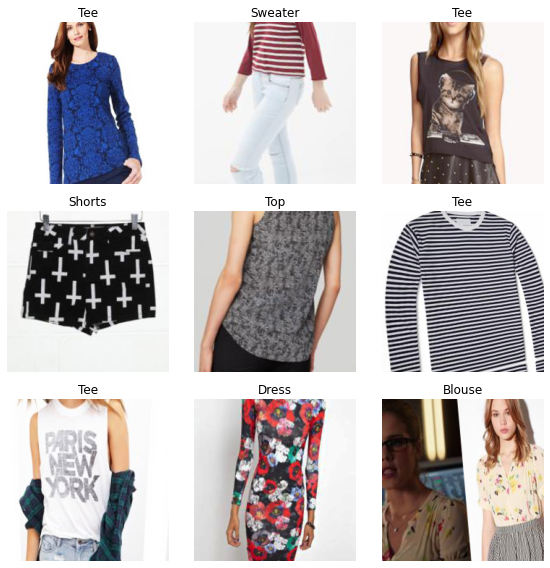

In [15]:
train_image_list = ImageList.from_df(df=data_df, path=root_path, cols='image_name').split_by_idxs(
    (data_df[data_df['evaluation_status']=='train'].index),
    (data_df[data_df['evaluation_status']=='val'].index)).label_from_df(cols='category_name')
test_image_list = ImageList.from_df(df=data_df[data_df['evaluation_status'] == 'test'], path=root_path, cols='image_name')

data = train_image_list.transform(get_transforms(), size=224).databunch(bs=128).normalize(imagenet_stats)
data.add_test(test_image_list)
data.show_batch(rows=3, figsize=(8,8))

# Conduct Transfer Learning from RestNet

## Restnet18/50

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-02
Min loss divided by 10: 1.45E-02


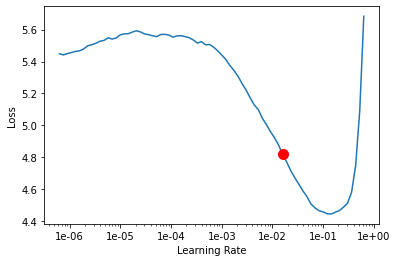

In [16]:
# see models available: https://docs.fast.ai/vision.models.html
# many options for Resnet, the numbers are the number of layers. 
# More layers are generally more accurate but take longer to train: resnet18, resnet34, resnet50, resnet101, resnet152
# get top 1 and top 5 accuracy
def train_model(data, pretrained_model, model_metrics):
    learner = cnn_learner(data, pretrained_model, metrics=model_metrics)
    learner.model = torch.nn.DataParallel(learner.model)
    learner.lr_find()
    learner.recorder.plot(suggestion=True)
    return learner

pretrained_model = models.resnet18 # simple model that can be trained on free tier
# pretrained_model = models.resnet50 # need pro tier, model I used

model_metrics = [accuracy, partial(top_k_accuracy, k=1), partial(top_k_accuracy, k=5)]
learner = train_model(data, pretrained_model, model_metrics)

In [17]:
learner.fit_one_cycle(10, max_lr=1e-02)

## Evaluate Model

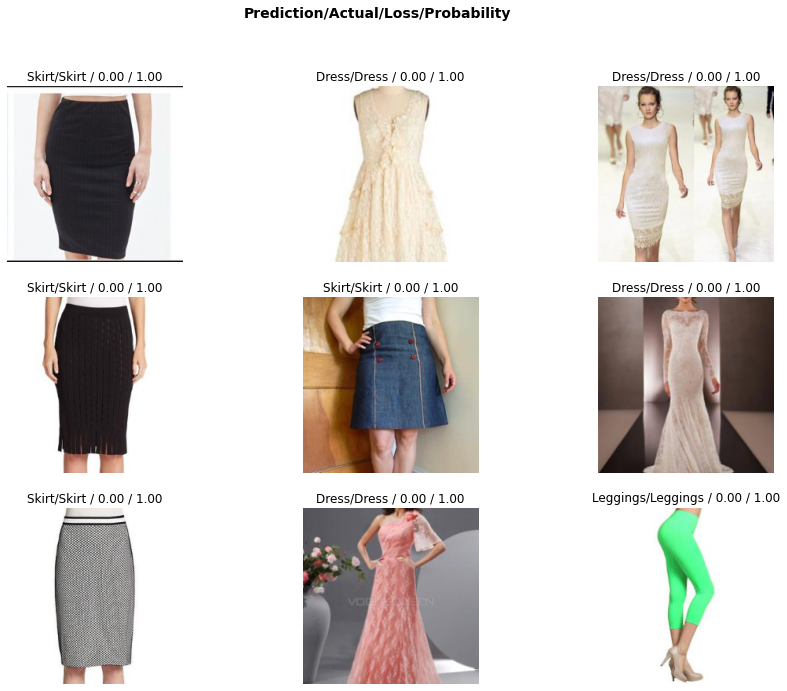

In [18]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_top_losses(9, largest=False, figsize=(15,11), heatmap_thresh=5)

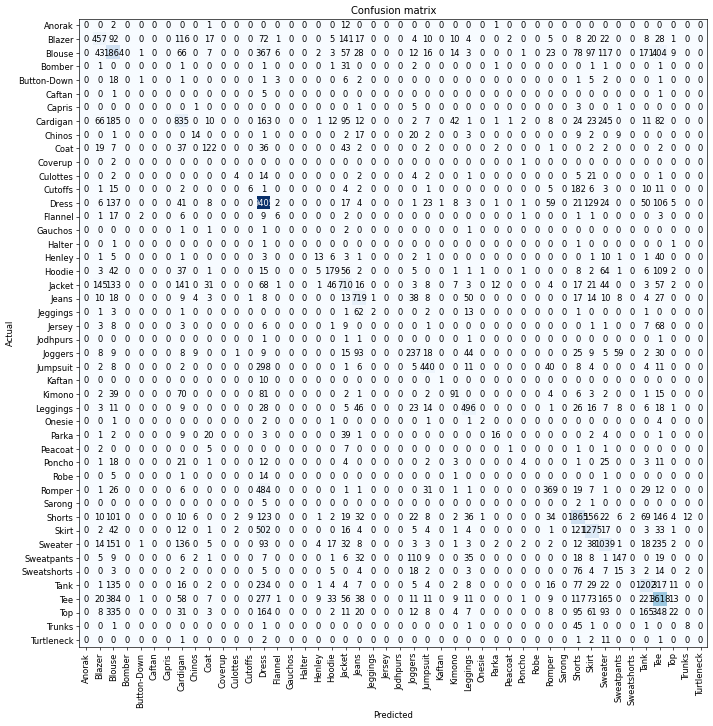

In [19]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [20]:
# saving the model (temporary, will lose model once environment resets)
learner.save('resnet-fashion')

In [21]:
# saving the model (permanent)
save_models_parent_url = '/content/drive/My Drive/Springboard MLE Track/Colab Artifacts/Step_03_Baseline/Models/'

learner.save(f'{save_models_parent_url}resnet18-fashion')
#learner.save(f'{save_models_parent_url}resnet50-fashion')

In [22]:
# view model details
learner.model.module

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

# Use Fast.ai hooks to retrieve image embeddings

In [23]:
class SaveFeatures():
    features=None
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
        self.features = None
    def hook_fn(self, module, input, output): 
        out = output.detach().cpu().numpy()
        if isinstance(self.features, type(None)):
            self.features = out
        else:
            self.features = np.row_stack((self.features, out))
    def remove(self): 
        self.hook.remove()

In [24]:
def load_learner(data, pretrained_model, model_metrics, model_path):
    learner = cnn_learner(data, pretrained_model, metrics=model_metrics)
    learner.model = torch.nn.DataParallel(learner.model)
    learner = learner.load(model_path)
    return learner

pretrained_model = models.resnet18 # simple model that can be trained on free tier
# pretrained_model = models.resnet50 # need pro tier

model_metrics = [accuracy, partial(top_k_accuracy, k=1), partial(top_k_accuracy, k=5)]
# if gdrive not mounted:
#drive.mount('/content/gdrive') 


model_path = f"{save_models_parent_url}/resnet18-fashion"
# model_path = "/content/gdrive/My Drive/resnet50-fashion"
learner = load_learner(data, pretrained_model, model_metrics, model_path)

In [25]:
# takes time to populate the embeddings for each image
# Get 2nd last layer of the model that stores the embedding for the image representations
# the last linear layer is the output layer.
saved_features = SaveFeatures(learner.model.module[1][4])
_= learner.get_preds(data.train_ds)
_= learner.get_preds(DatasetType.Valid)

In [26]:
# prepare the data for generating recommendations (exlcude test data)
# get the embeddings from trained model
img_path = [str(x) for x in (list(data.train_ds.items) +list(data.valid_ds.items))]
label = [data.classes[x] for x in (list(data.train_ds.y.items) +list(data.valid_ds.y.items))]
label_id = [x for x in (list(data.train_ds.y.items) +list(data.valid_ds.y.items))]
data_df_ouput = pd.DataFrame({'img_path': img_path, 'label': label, 'label_id': label_id})
data_df_ouput['embeddings'] = np.array(saved_features.features).tolist()
data_df_ouput

img_path  ...                                         embeddings
0       ./img/Sheer_Pleated-Front_Blouse/img_00000001.jpg  ...  [23.299274444580078, 0.25743478536605835, -0.0...
1       ./img/Sheer_Pleated-Front_Blouse/img_00000002.jpg  ...  [72.26564025878906, -76.33822631835938, -34.92...
2       ./img/Sheer_Pleated-Front_Blouse/img_00000004.jpg  ...  [-52.83346176147461, 19.070812225341797, -29.4...
3       ./img/Sheer_Pleated-Front_Blouse/img_00000008.jpg  ...  [20.011690139770508, -3.992319345474243, -19.0...
4       ./img/Sheer_Pleated-Front_Blouse/img_00000009.jpg  ...  [-24.958053588867188, -3.8468668460845947, -16...
...                                                   ...  ...                                                ...
249187  ./img/Paisley_Print_Babydoll_Dress/img_0000003...  ...  [-66.89777374267578, 26.485055923461914, -13.3...
249188  ./img/Paisley_Print_Babydoll_Dress/img_0000004...  ...  [-19.00726318359375, 25.642751693725586, -6.94...
249189  ./img/Paisley_Print_Babydoll_Dress/img_0000004...  ...  [-20.085647583007812, 41.86491012573242, 19.82...
249190  ./img/Paisley_Print_Babydoll_Dress/img_0000004...  ...  [6.6028313636779785, -0.03599673509597778, -43...
249191  ./img/Paisley_Print_Babydoll_Dress/img_0000005...  ...  [-59.34276580810547, 42.61550521850586, -42.89...

[249192 rows x 4 columns]

# Use Annoy to obtain most similar images

In [27]:
# Using Spotify's Annoy
def get_similar_images_annoy(annoy_tree, img_index, number_of_items=12):
    start = time.time()
    img_id, img_label  = data_df_ouput.iloc[img_index, [0, 1]]
    similar_img_ids = annoy_tree.get_nns_by_item(img_index, number_of_items+1)
    end = time.time()
    print(f'{(end - start) * 1000} ms')
    # ignore first item as it is always target image
    return img_id, img_label, data_df_ouput.iloc[similar_img_ids[1:]] 


# for images similar to centroid 
def get_similar_images_annoy_centroid(annoy_tree, vector_value, number_of_items=12):
    start = time.time()
    similar_img_ids = annoy_tree.get_nns_by_vector(vector_value, number_of_items+1)
    end = time.time()
    print(f'{(end - start) * 1000} ms')
    # ignore first item as it is always target image
    return data_df_ouput.iloc[similar_img_ids[1:]] 


def show_similar_images(similar_images_df, fig_size=[10,10], hide_labels=True):
    if hide_labels:
        category_list = []
        for i in range(len(similar_images_df)):
            # replace category with blank so it wont show in display
            category_list.append(CategoryList(similar_images_df['label_id'].values*0,
                                              [''] * len(similar_images_df)).get(i))
    else:
        category_list = [learner.data.train_ds.y.reconstruct(y) for y in similar_images_df['label_id']]
    return learner.data.show_xys([open_image(img_id) for img_id in similar_images_df['img_path']],
                                category_list, figsize=fig_size)

In [28]:
# more tree = better approximation
ntree = 100
#"angular", "euclidean", "manhattan", "hamming", or "dot"
metric_choice = 'angular'

annoy_tree = AnnoyIndex(len(data_df_ouput['embeddings'][0]), metric=metric_choice)

# # takes a while to build the tree
for i, vector in enumerate(data_df_ouput['embeddings']):
    annoy_tree.add_item(i, vector)
_  = annoy_tree.build(ntree)

## Embeddings Centroid Detection

In [29]:
def centroid_embedding(outfit_embedding_list):
    number_of_outfits = outfit_embedding_list.shape[0]
    length_of_embedding = outfit_embedding_list.shape[1]
    centroid = []
    for i in range(length_of_embedding):
        centroid.append(np.sum(outfit_embedding_list[:, i])/number_of_outfits)
    return centroid

187299


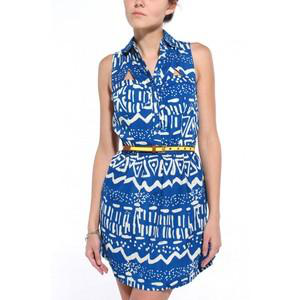

In [30]:
# image explorer 
img_index = np.random.randint(len(data_df_ouput),size=1)[0]
print(img_index)
open_image(data_df_ouput.iloc[img_index, 0])

### Anything with Shorts

In [31]:
# shorts
outfit_img_ids = [109938, 106385, 113703, 98666, 113467, 120667, 20840, 8450, 142843, 238607, 124505,222671]
outfit_embedding_list = []
for img_index in outfit_img_ids:
    outfit_embedding_list.append(data_df_ouput.iloc[img_index, 3])

outfit_embedding_list = np.array(outfit_embedding_list)
outfit_centroid_embedding = centroid_embedding(outfit_embedding_list)
outfits_selected = data_df_ouput.iloc[outfit_img_ids] 

similar_images_df = get_similar_images_annoy_centroid(annoy_tree, outfit_centroid_embedding, 30)

1.865386962890625 ms


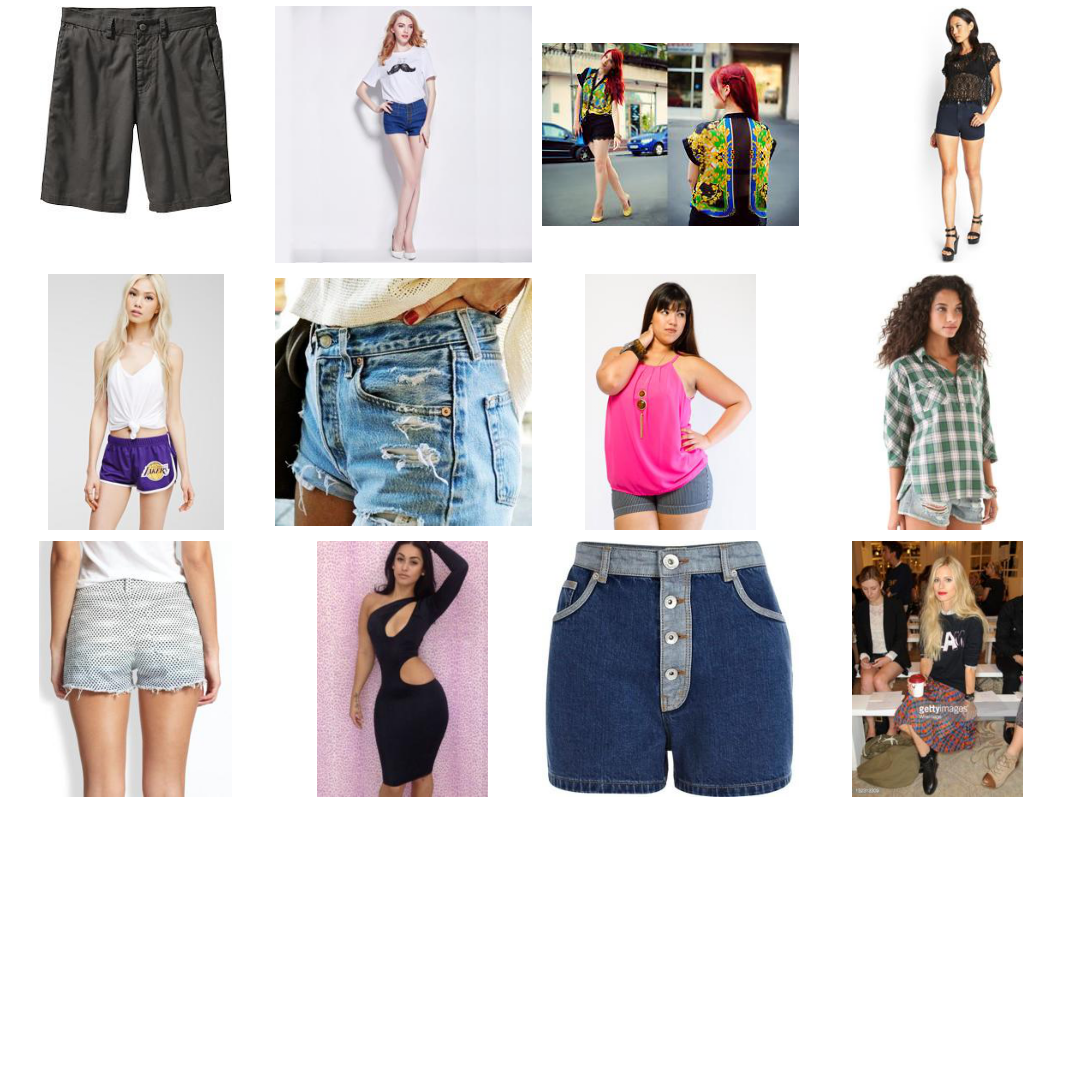

In [32]:
show_similar_images(outfits_selected, fig_size=[15,15])

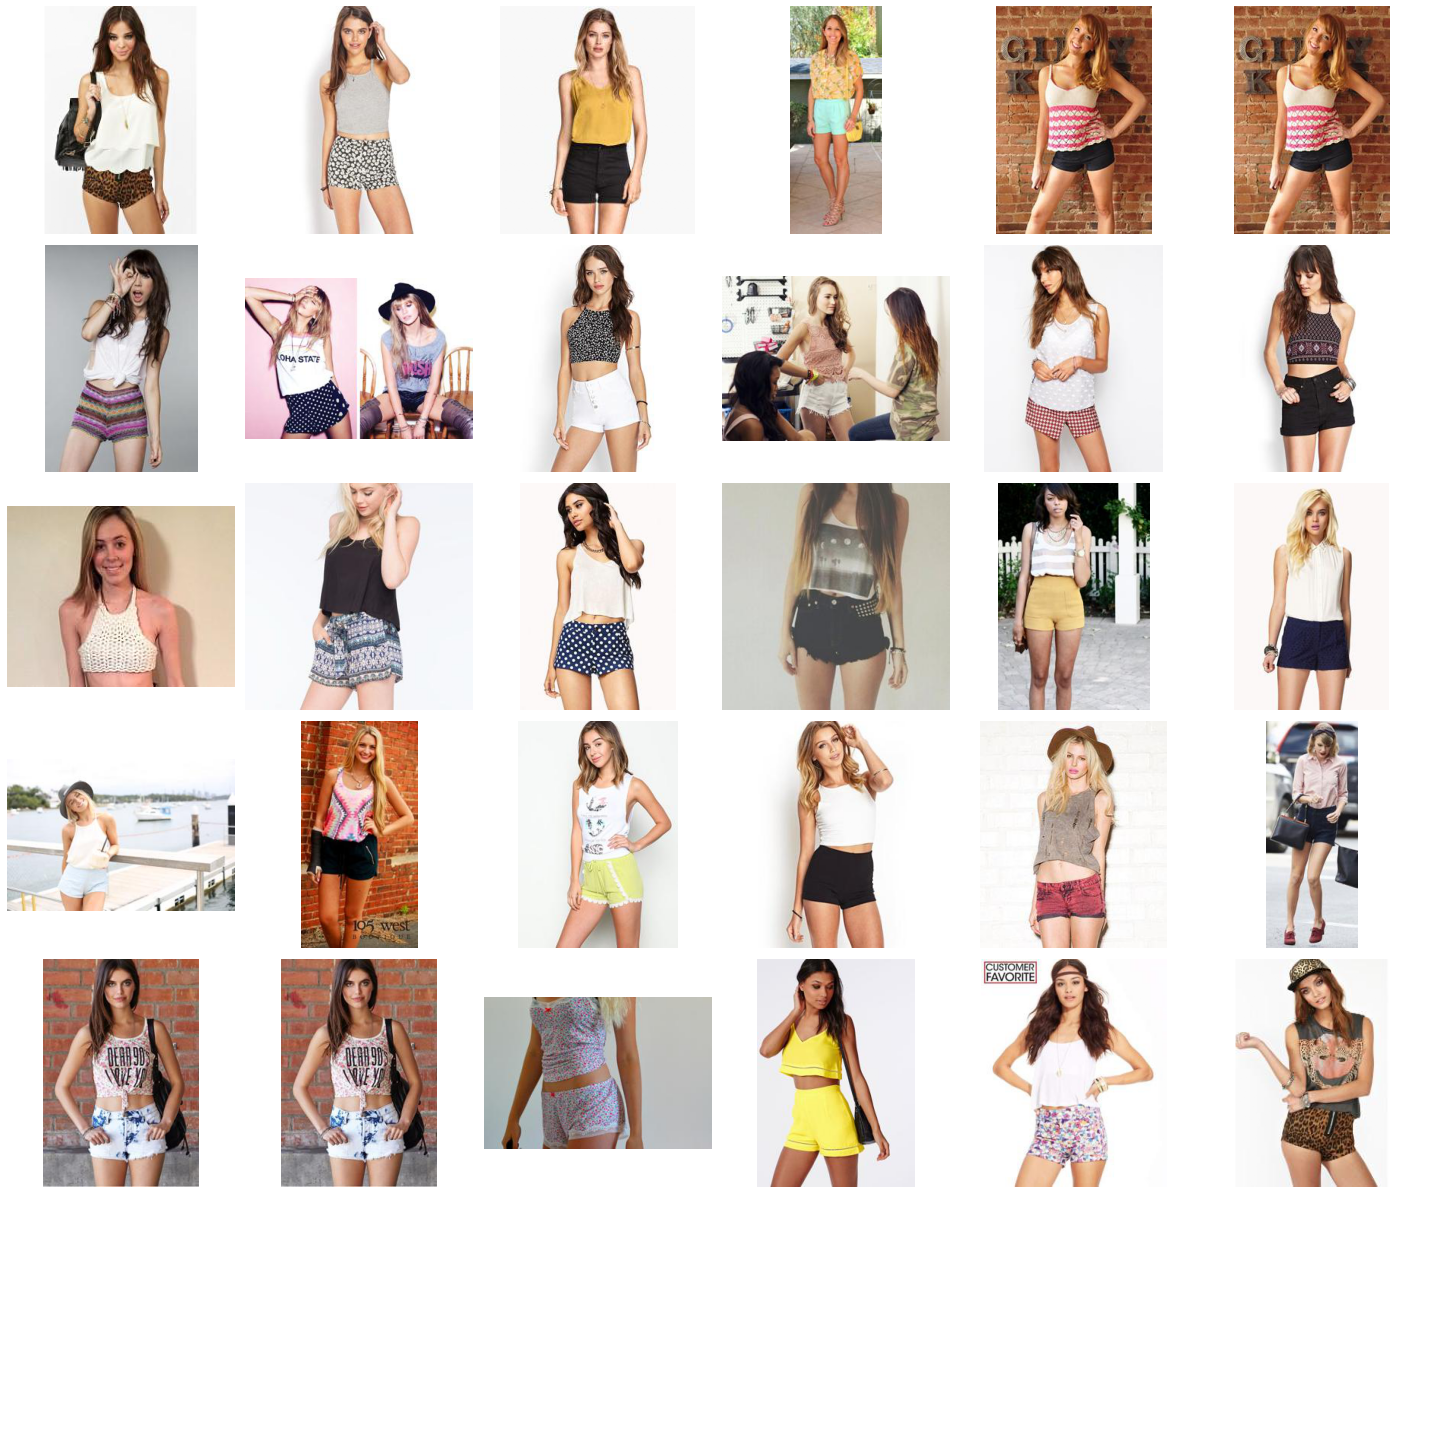

In [33]:
show_similar_images(similar_images_df, fig_size=[20,20])

### Urban Lifestyle

In [34]:
# urban 

outfit_img_ids = [50374, 226654, 60186, 56384, 46254, 212771, 118639, 33918, 228773, 46332, 118173, 146836]
outfit_embedding_list = []
for img_index in outfit_img_ids:
    outfit_embedding_list.append(data_df_ouput.iloc[img_index, 3])

outfit_embedding_list = np.array(outfit_embedding_list)
outfit_centroid_embedding = centroid_embedding(outfit_embedding_list)
outfits_selected = data_df_ouput.iloc[outfit_img_ids] 

similar_images_df = get_similar_images_annoy_centroid(annoy_tree, outfit_centroid_embedding, 30)

2.0275115966796875 ms


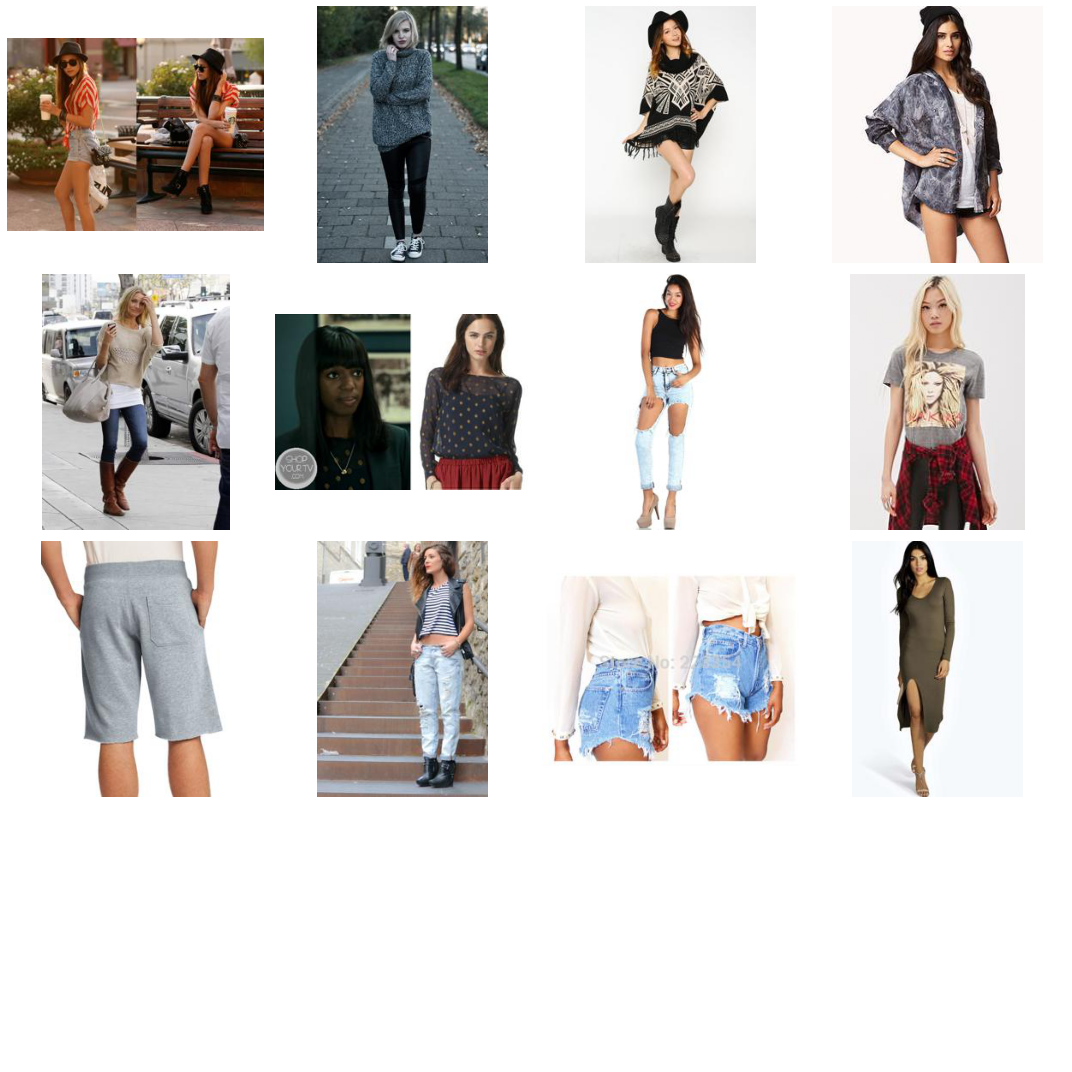

In [35]:
show_similar_images(outfits_selected, fig_size=[15,15])

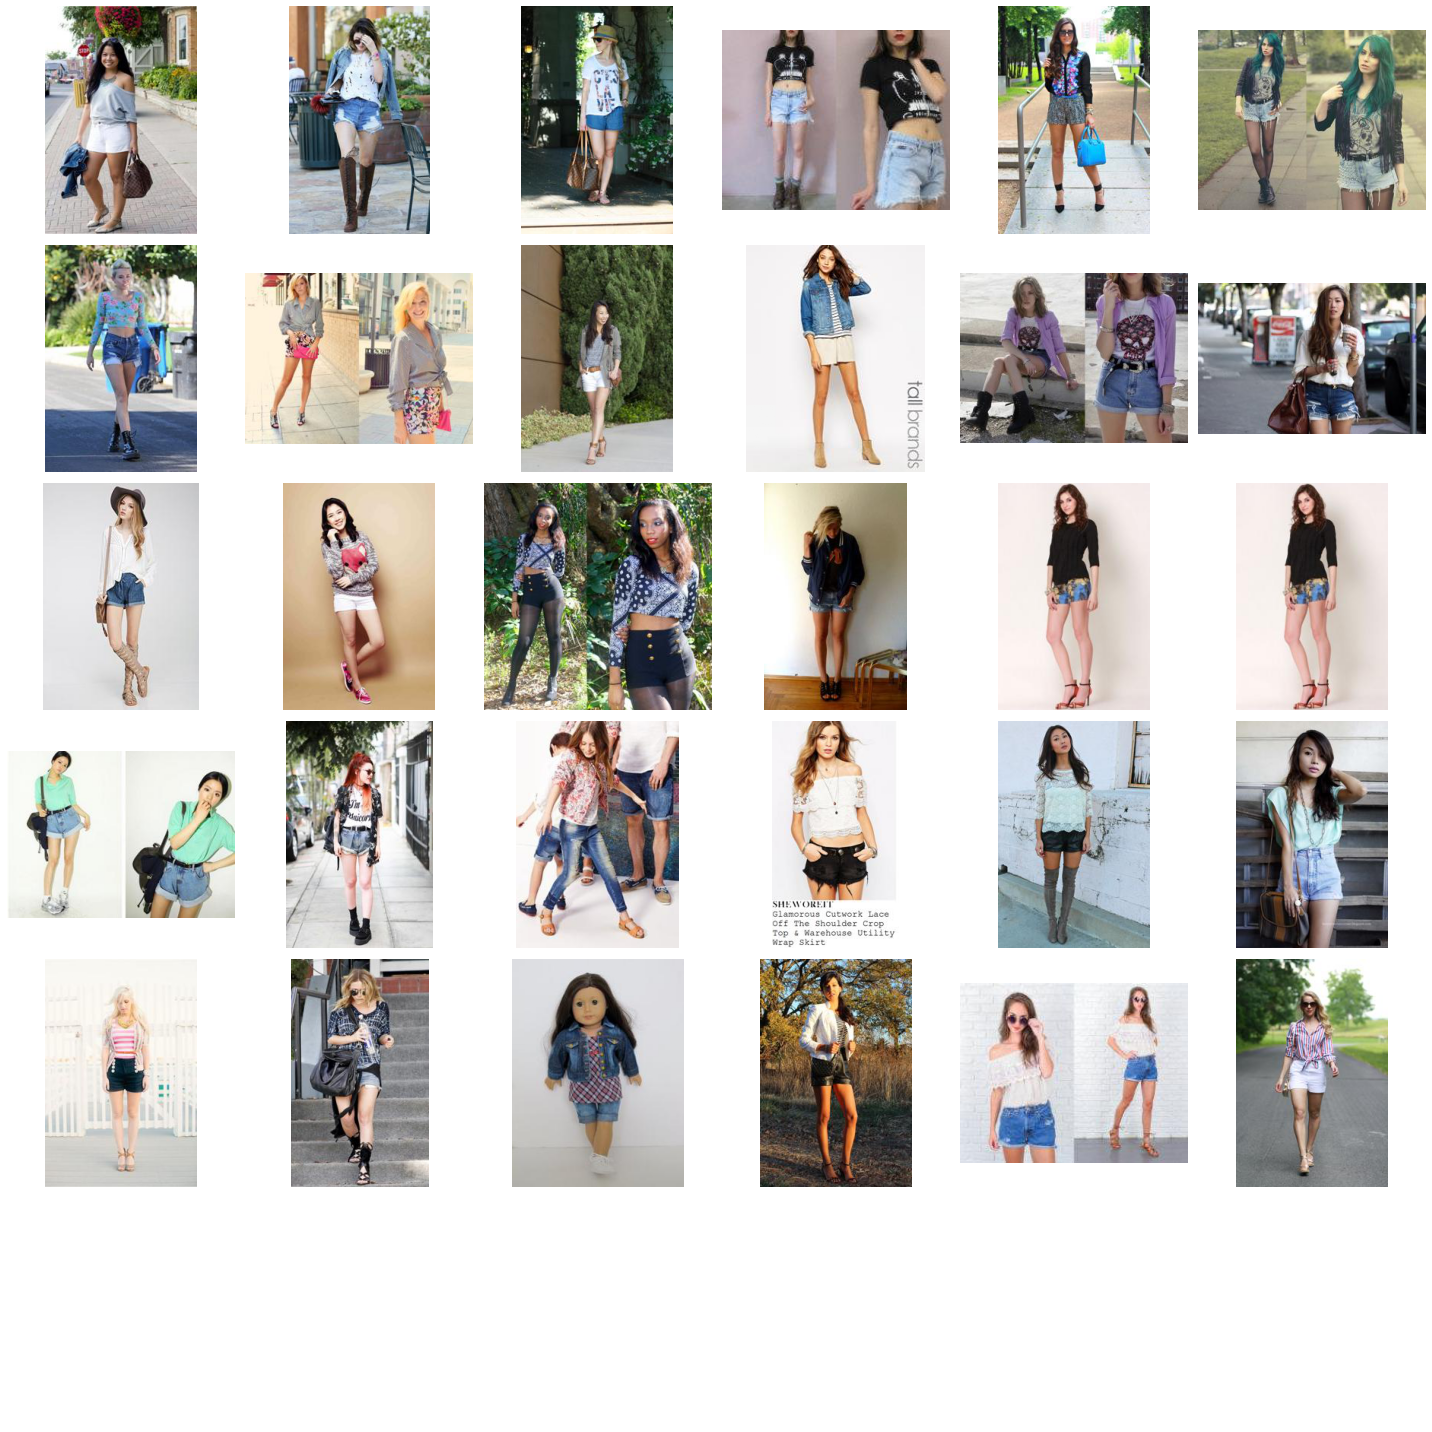

In [36]:
show_similar_images(similar_images_df, fig_size=[20,20])

### Flowery Dreams

In [37]:
# flower theme

outfit_img_ids = [171787, 168315, 194847,244804, 153507, 166507, 172396, 14497, 200965, 162629,241277, 126155]
outfit_embedding_list = []
for img_index in outfit_img_ids:
    outfit_embedding_list.append(data_df_ouput.iloc[img_index, 3])

outfit_embedding_list = np.array(outfit_embedding_list)
outfit_centroid_embedding = centroid_embedding(outfit_embedding_list)
outfits_selected = data_df_ouput.iloc[outfit_img_ids] 

similar_images_df = get_similar_images_annoy_centroid(annoy_tree, outfit_centroid_embedding, 30)

2.0492076873779297 ms


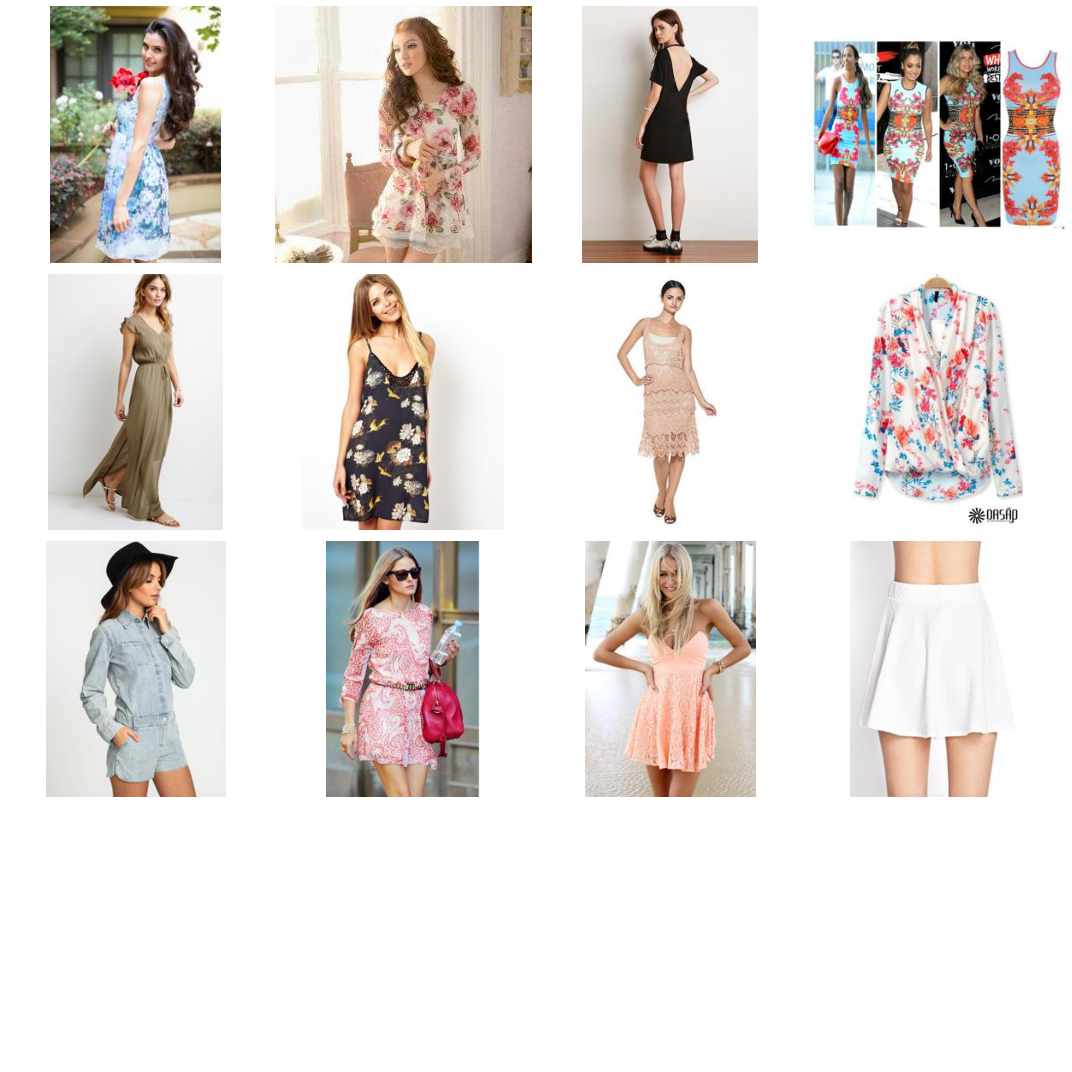

In [38]:
show_similar_images(outfits_selected, fig_size=[15,15])